In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import awkward as ak
import vector
import mplhep as hep
hep.style.use(hep.style.CMS)
import tensorflow as tf
import tensorflow.keras
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, confusion_matrix, auc, roc_curve
from tensorflow.keras.layers import Dense, Dropout, LSTM, concatenate, GRU,Masking, Activation, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.backend import sigmoid
from tensorflow.keras import regularizers
from keras.utils.generic_utils import get_custom_objects
import sys
import random
from math import sqrt
from tqdm import tqdm
import pickle as pkl

2022-12-06 17:49:12.076824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorfl

In [2]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
import keras
import tensorflow as tf
tf.random.set_seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
from keras import backend as K
K.set_session(sess)

2022-12-06 17:49:17.031057: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 17:49:17.033669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tor

In [29]:
dnn_name = 'DNN_phase1_test_highpt'
folder = './DNNmodel/'+dnn_name+'/'
if not os.path.exists(folder):
    os.mkdir(folder)

In [4]:
file = open("/eos/home-a/acagnott/DarkMatter/trainingSet/trainingset.pkl", "rb")
dict_samples = pkl.load(file)
file.close()

In [5]:
categories = ['3j1fj', '3j0fj','2j1fj']
datasets = ['tDM_mPhi1000_mChi1', 'QCD_HT1000', 'TT_Mtt-700to1000', 'TT_Mtt-1000toInf']

In [6]:
#dict_samples['tDM_mPhi1000_mChi1']['3j1fj'][0][dict_samples['tDM_mPhi1000_mChi1']['3j1fj'][-1].reshape(-1)>250]

In [7]:
for d in datasets:
    for c in categories:
        idx_falsetop = [i for i, x in enumerate(dict_samples[d][c][3]==0) if x==True]
        ids_todrop = random.sample(idx_falsetop, int(len(idx_falsetop)*(2/3)))
        dict_samples[d][c][0] = np.delete(dict_samples[d][c][0], ids_todrop, axis=0)
        dict_samples[d][c][1] = np.delete(dict_samples[d][c][1], ids_todrop, axis=0)
        dict_samples[d][c][2] = np.delete(dict_samples[d][c][2], ids_todrop, axis=0)
        dict_samples[d][c][3] = np.delete(dict_samples[d][c][3], ids_todrop, axis=0)
        dict_samples[d][c][4] = np.delete(dict_samples[d][c][4], ids_todrop, axis=0)

In [8]:
pt_sep = 250

In [9]:
X_jet_lowpt = np.concatenate([dict_samples[d][c][0][dict_samples[d][c][-1].reshape(-1)<pt_sep]
                              for d in datasets for c in categories ])
#X_fatjet_lowpt = np.concatenate([dict_samples[d][c][1][dict_samples[d][c][-1].reshape(-1)<pt_sep]
#                                 for d in datasets for c in categories])
X_mass_lowpt = np.concatenate([dict_samples[d][c][2][dict_samples[d][c][-1].reshape(-1)<pt_sep]
                               for d in datasets for c in categories])
                          
y_lowpt = np.concatenate([dict_samples[d][c][3][dict_samples[d][c][-1].reshape(-1)<pt_sep]
                          for d in datasets for c in categories] )

In [10]:
X_jet_highpt = np.concatenate([dict_samples[d][c][0][dict_samples[d][c][-1].reshape(-1)>pt_sep] 
                               for d in datasets for c in categories ])
X_fatjet_highpt = np.concatenate([dict_samples[d][c][1][dict_samples[d][c][-1].reshape(-1)>pt_sep]
                                  for d in datasets for c in categories])
X_mass_highpt = np.concatenate([dict_samples[d][c][2][dict_samples[d][c][-1].reshape(-1)>pt_sep]
                                for d in datasets for c in categories])
                          
y_highpt = np.concatenate([dict_samples[d][c][3][dict_samples[d][c][-1].reshape(-1)>pt_sep]
                           for d in datasets for c in categories] )

In [11]:
X_jet_highpt_train, X_jet_highpt_test, X_fatjet_highpt_train, X_fatjet_highpt_test, X_mass_highpt_train, X_mass_highpt_test, y_highpt_train, y_highpt_test = train_test_split(X_jet_highpt, X_fatjet_highpt, X_mass_highpt, y_highpt, stratify=y_highpt, shuffle=True, test_size=0.3)

In [12]:
#((86179, 3, 8), (36935, 3, 8))  --> training set, test set 
#(968.0, 415.0) ---> true event in train, test

In [13]:
X_jet_highpt_train.shape, X_jet_highpt_test.shape, 

((26806, 3, 8), (11489, 3, 8))

In [14]:
np.sum(y_highpt_train), np.sum(y_highpt_test) 

(2451.0, 1051.0)

In [15]:
dropout = 0.1

fj_inputs = tf.keras.Input(shape=(X_fatjet_highpt_train.shape[1],), name = 'fatjet')        #x
jet_inputs = tf.keras.Input(shape=(None,X_jet_highpt_train.shape[2],), name = 'jet')    #y
#mass_input = tf.keras.Input(shape=(2, ), name = 'top_mass')
#x = Masking(mask_value=0)(fj_inputs) # ultima modifica
x = BatchNormalization()(fj_inputs)
x = Dense(3, activation = 'tanh',kernel_initializer="random_normal")(x)

y = Masking(mask_value=0.)(jet_inputs)
y = BatchNormalization()(y)
y = keras.layers.LSTM(1, activation='tanh', kernel_initializer="random_normal")(y)#, dropout = dropout

x = concatenate([x,y])
x = Dense(2, activation ='tanh',kernel_initializer="random_normal")(x)
x = Dropout(dropout)(x)

outputs = Dense(1, activation='sigmoid')(x) 
#model = tf.keras.Model(inputs=[fj_inputs, jet_inputs, mass_input], outputs=outputs)
model = tf.keras.Model(inputs=[fj_inputs, jet_inputs], outputs=outputs)

In [16]:
trainer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=trainer, loss=loss, metrics=[tf.keras.metrics.AUC()])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 jet (InputLayer)               [(None, None, 8)]    0           []                               
                                                                                                  
 fatjet (InputLayer)            [(None, 12)]         0           []                               
                                                                                                  
 masking (Masking)              (None, None, 8)      0           ['jet[0][0]']                    
                                                                                                  
 batch_normalization (BatchNorm  (None, 12)          48          ['fatjet[0][0]']                 
 alization)                                                                                   

In [18]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                           mode='min',# quantity that has to be monitored(to be minimized in this case)
                                           patience = 30, # Number of epochs with no improvement after which training will be stopped.
                                           min_delta = 1e-5,
                                           restore_best_weights = True) # update the model with the best-seen weights

#Reduce learning rate when a metric has stopped improving
reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor = 'loss',
                                              mode='min',# quantity that has to be monitored
                                              min_delta=1e-5,
                                              factor = 0.1, # factor by which LR has to be reduced...
                                              patience = 10, #...after waiting this number of epochs with no improvements 
                                              #on monitored quantity
                                              min_lr= 1e-15 ) 


#callback_list = [reduce_LR, early_stop]
callback_list = [early_stop]

In [19]:
epochs = 10000
batch_size = 100#500

#history = model.fit({'fatjet': X_fatjet_train, 'jet':X_jet_train, 'top_mass': X_mass_train}, y_train, callbacks=callback_list, 
#                    validation_split = 0.1,
#                    epochs=epochs, batch_size=batch_size, verbose=1)
history = model.fit({'fatjet': X_fatjet_highpt_train, 'jet':X_jet_highpt_train}, y_highpt_train, callbacks=callback_list, 
                    validation_split = 0.15,
                    epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/10000
228/228 [==============================] - 8s 12ms/step - loss: 0.3172 - auc: 0.6599 - val_loss: 0.2478 - val_auc: 0.8224
Epoch 2/10000
228/228 [==============================] - 1s 4ms/step - loss: 0.2462 - auc: 0.8243 - val_loss: 0.2257 - val_auc: 0.8568
Epoch 3/10000
228/228 [==============================] - 1s 4ms/step - loss: 0.2320 - auc: 0.8516 - val_loss: 0.2048 - val_auc: 0.8798
Epoch 4/10000
228/228 [==============================] - 1s 3ms/step - loss: 0.2051 - auc: 0.8963 - val_loss: 0.1850 - val_auc: 0.9121
Epoch 5/10000
228/228 [==============================] - 1s 3ms/step - loss: 0.1940 - auc: 0.9103 - val_loss: 0.1862 - val_auc: 0.9168
Epoch 6/10000
228/228 [==============================] - 1s 3ms/step - loss: 0.1897 - auc: 0.9164 - val_loss: 0.1815 - val_auc: 0.9194
Epoch 7/10000
228/228 [==============================] - 1s 4ms/step - loss: 0.1840 - auc: 0.9222 - val_loss: 0.1772 - val_auc: 0.9217
Epoch 8/10000
228/228 [==============================]

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


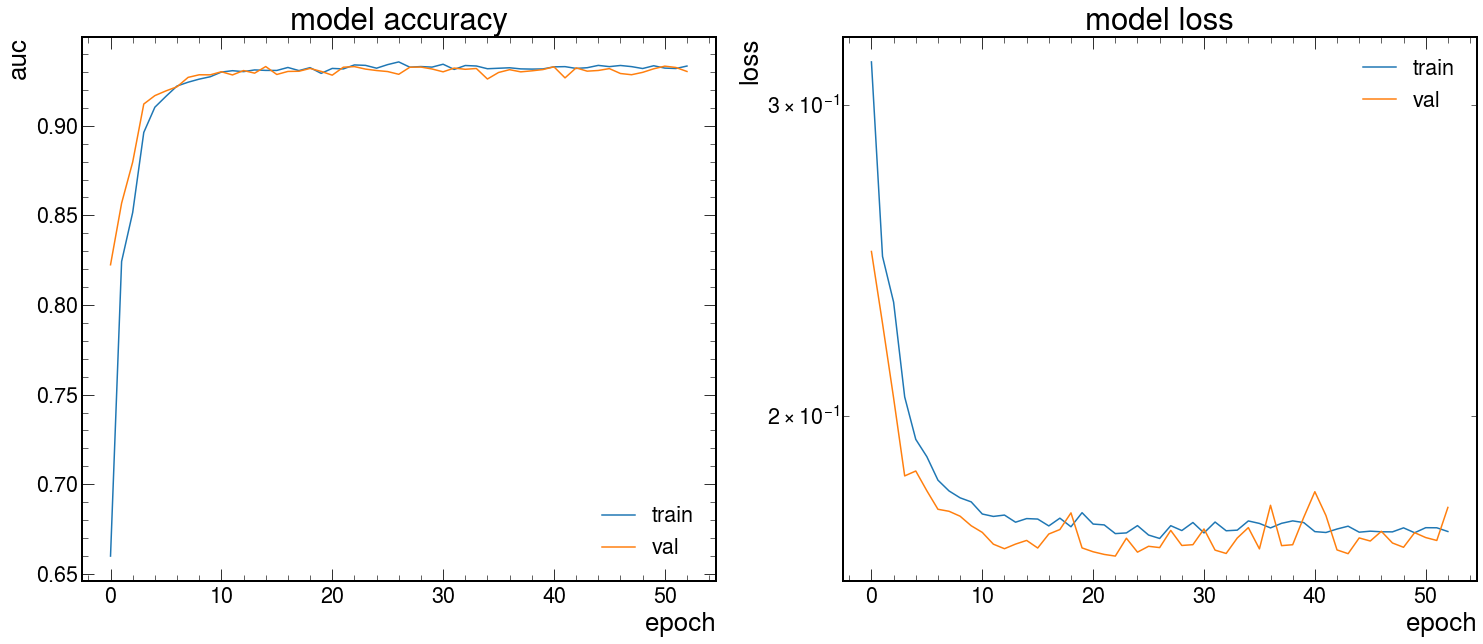

In [30]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
fig, ax = plt.subplots(ncols=2, figsize=(25,10))
for var in history.history.keys():
    if ('loss' in var) and (not 'val' in var): ax[1].plot(history.history[var], label ='train')
    if 'val_loss' in var: ax[1].plot(history.history[var], label ='val')
    if ('auc' in var) and (not 'val' in var): ax[0].plot(history.history[var], label ='train')
    if 'val_auc' in var : ax[0].plot(history.history[var], label ='val')

ax[0].set_title('model accuracy')
ax[0].set_ylabel('auc')
ax[0].set_xlabel('epoch')
ax[0].legend()
# summarize history for loss
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend()
ax[1].set_yscale('Log')
plt.savefig(folder+'auc_loss.png')

In [21]:
#model.evaluate({'fatjet': X_fatjet_test, 'jet': X_jet_test, 'top_mass': X_mass_test}, y_test)
model.evaluate({'fatjet': X_fatjet_highpt_test, 'jet': X_jet_highpt_test}, y_highpt_test)

360/360 [==============================] - 1s 1ms/step - loss: 0.1750 - auc: 0.9301


[0.17498263716697693, 0.9300957918167114]

In [22]:
#y_pred = model.predict({'fatjet': X_fatjet_test, 'jet': X_jet_test, 'top_mass': X_mass_test})
#y_pred_train = model.predict({'fatjet': X_fatjet_train, 'jet': X_jet_train, 'top_mass': X_mass_train})
y_pred = model.predict({'fatjet': X_fatjet_highpt_test, 'jet': X_jet_highpt_test})
y_pred_train = model.predict({'fatjet': X_fatjet_highpt_train, 'jet': X_jet_highpt_train})

In [23]:
y_pred_train_bkg = y_pred_train[y_highpt_train==0]
y_pred_train_sgn = y_pred_train[y_highpt_train==1]
y_pred_bkg = y_pred[y_highpt_test==0]
y_pred_sgn = y_pred[y_highpt_test==1]

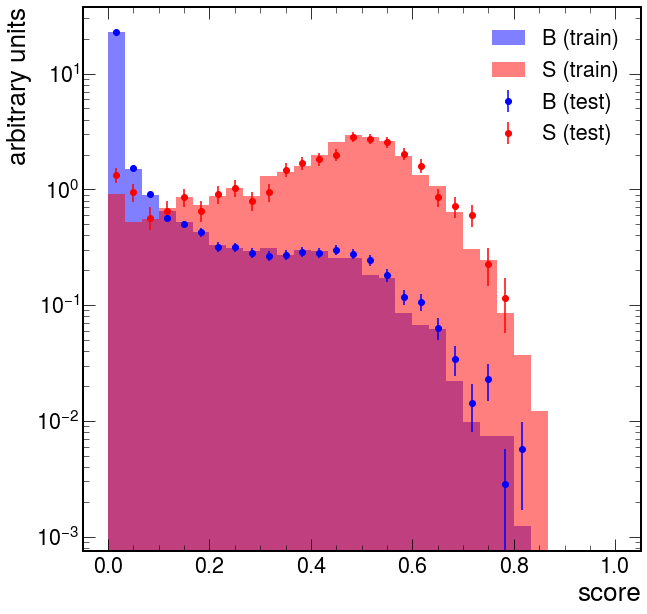

In [31]:
bins = 30

fig, ax = plt.subplots(figsize=(10,10))


bins_count_bkg = ax.hist(y_pred_train_bkg, alpha=0.5, color='blue', 
                         density=True, label='B (train)', range = [0,1], bins = bins)
bins_count_sgn = ax.hist(y_pred_train_sgn, alpha=0.5,color='red', 
                         density=True, label='S (train)', range = [0,1], bins = bins)

hist, bins = np.histogram(y_pred_bkg, range = [0,1], bins=bins, density=True)
scale = len(y_pred_bkg) / sum(hist)
err = np.sqrt(hist * scale) / scale
center = (bins[:-1] + bins[1:]) / 2
ax.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

hist, bins = np.histogram(y_pred_sgn, range = [0,1], bins=bins, density=True)
scale = len(y_pred_sgn) / sum(hist)
err = np.sqrt(hist * scale) / scale
center = (bins[:-1] + bins[1:]) / 2
ax.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

ax.set_xlabel('score')
ax.set_ylabel('arbitrary units')
ax.legend()
plt.yscale('Log')
plt.savefig(folder+'traintestDiscrimination.png')

In [26]:
y_score = y_pred.ravel()
print(len(y_score))
y_true = y_highpt_test.ravel()
print(len(y_true))

11489
11489


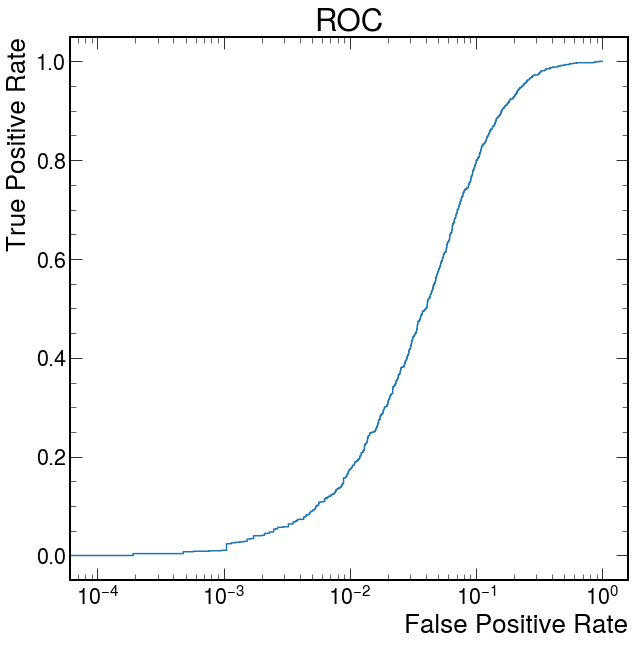

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, trs =roc_curve(y_true = y_true, y_score = y_score, pos_label=1)
fig, ax = plt.subplots()
ax.plot(fpr, tpr) 
ax.set_title('ROC')
ax.set_xlabel('False Positive Rate') 
ax.set_ylabel('True Positive Rate') 
plt.xscale('Log')
plt.savefig(folder+'ROC.png')

In [33]:
dnn_name = 'DNN_phase1_test_highpt'
folder = './DNNmodel/'+dnn_name+'/'
if not os.path.exists(folder):
    os.mkdir(folder)
model.save(folder+dnn_name+".h5")

In [34]:
print('10%   trs', trs[fpr<0.1][-1], 'tpr ',tpr[fpr<0.1][-1])
print('5%    trs',trs[fpr<0.05][-1], 'tpr ', tpr[fpr<0.05][-1])
print('1%    trs',trs[fpr<0.01][-1], 'tpr ', tpr[fpr<0.01][-1])
print('0.1%  trs',trs[fpr<0.001][-1], 'tpr ', tpr[fpr<0.001][-1])

10%   trs 0.24163294 tpr  0.7944814462416746
5%    trs 0.41868246 tpr  0.5746907706945766
1%    trs 0.58162796 tpr  0.17507136060894388
0.1%  trs 0.7355943 tpr  0.010466222645099905


In [42]:
tresholds = {'fpr 10': trs[fpr<0.1][-1], 
      'fpr 5': trs[fpr<0.05][-1], 
      'fpr 1': trs[fpr<0.01][-1], 
      'fpr 01':trs[fpr<0.001][-1]}
with open(folder+"tresholds.pkl", "wb") as file:
    pkl.dump(tresholds, file)

In [36]:
t = [trs[fpr<0.1][-1], trs[fpr<0.05][-1], trs[fpr<0.01][-1], trs[fpr<0.001][-1]]

In [37]:
model = keras.models.load_model(folder+dnn_name+".h5")

In [38]:
file = open("/eos/home-a/acagnott/DarkMatter/trainingSet/trainingset.pkl", "rb")
dict_samples = pkl.load(file)
file.close()

In [39]:
X_jet = np.concatenate([dict_samples[d][c][0][dict_samples[d][c][-1].reshape(-1)>pt_sep] for d in datasets for c in categories ])
X_fatjet = np.concatenate([dict_samples[d][c][1][dict_samples[d][c][-1].reshape(-1)>pt_sep] for d in datasets for c in categories])
X_mass = np.concatenate([dict_samples[d][c][2][dict_samples[d][c][-1].reshape(-1)>pt_sep] for d in datasets for c in categories])
                          
y = np.concatenate([dict_samples[d][c][3][dict_samples[d][c][-1].reshape(-1)>pt_sep] for d in datasets for c in categories] )

In [40]:
#pred_all = model.predict({'fatjet': X_fatjet, 'jet': X_jet, 'top_mass': X_mass})
pred_all = model.predict({'fatjet': X_fatjet, 'jet': X_jet})

In [43]:
with open(folder+"tresholds.pkl", "rb") as file:
    tresholds=pkl.load(file)

tpr, fpr
0.8129640205596802 0.0957166786312515
tpr, fpr
0.5802398629354655 0.044958123953098825
tpr, fpr
0.16219303255282697 0.008260349365877004
tpr, fpr
0.011422044545973729 0.0006891600861450108


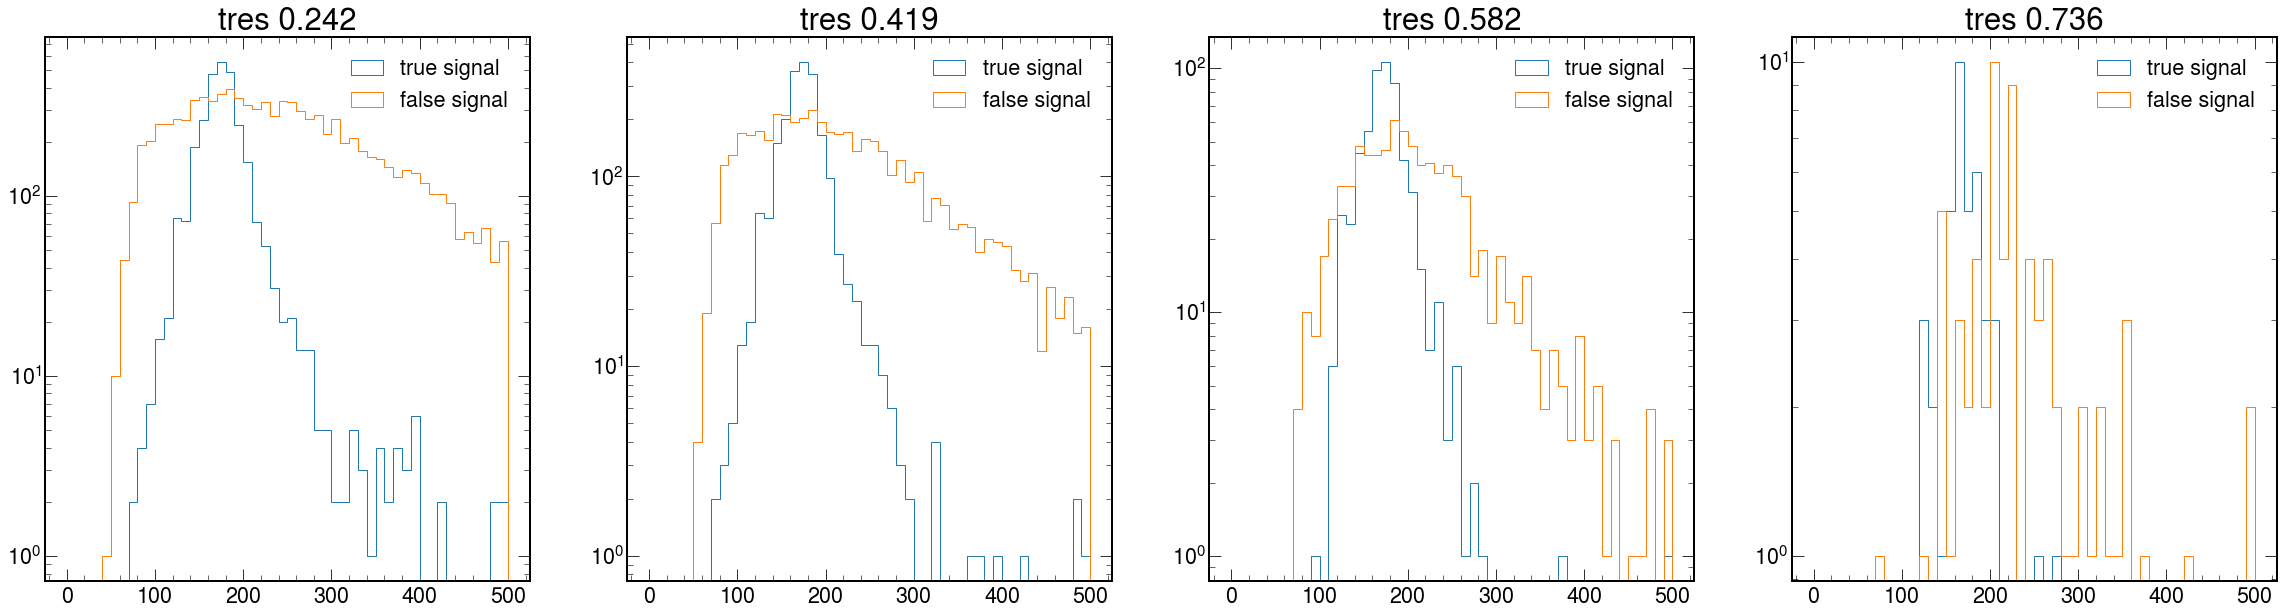

In [50]:
fig, ax = plt.subplots(ncols = 4, figsize = (40, 10))
bins = 50
rg = [0,500]
for n, tr in enumerate(tresholds.values()):
    ax[n].hist(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==1)], histtype = 'step',range = rg, bins = bins, label = 'true signal' )
    ax[n].hist(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==0)], histtype = 'step',range = rg, bins = bins, label = 'false signal' )
    ax[n].legend()
    ax[n].set_title('tres '+str(round(tr, 3)))
    ax[n].set_yscale('Log')
    print('tpr, fpr')
    print(len(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==1)])/len(X_mass[:,1][(y.flatten()==1)]), len(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==0)])/len(X_mass[:,1][(y.flatten()==0)]))
plt.savefig(folder+'mass_overtrs.png')

tpr, fpr
0.8129640205596802 0.0957166786312515
tpr, fpr
0.5802398629354655 0.044958123953098825
tpr, fpr
0.16219303255282697 0.008260349365877004
tpr, fpr
0.011422044545973729 0.0006891600861450108


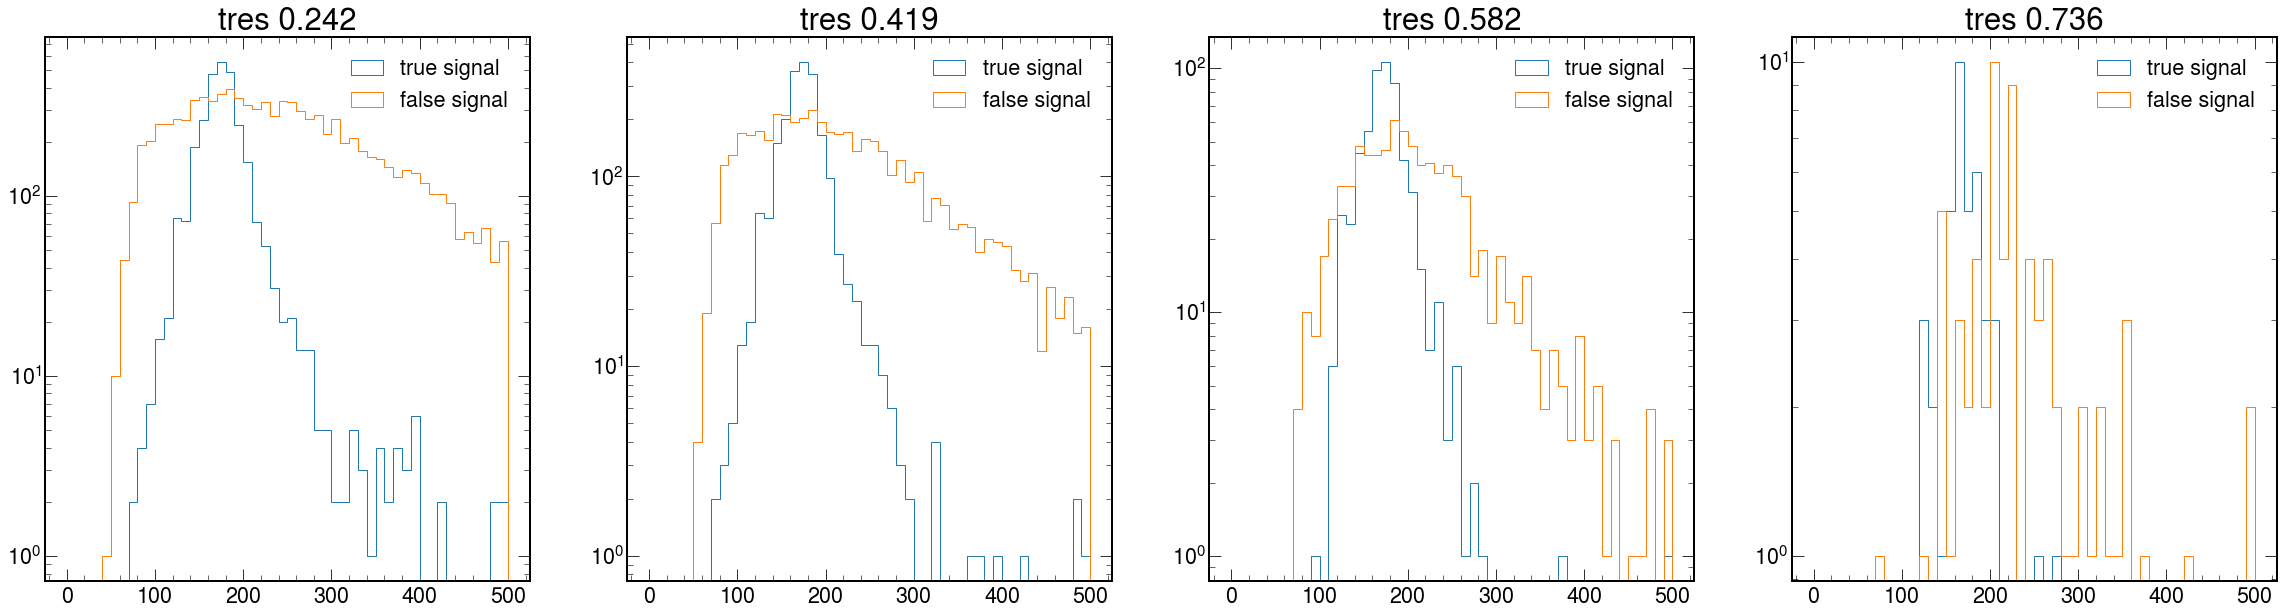

In [51]:
fig, ax = plt.subplots(ncols = 4, figsize = (40, 10))
bins = 50
rg = [0,500]
for n, tr in enumerate(tresholds.values()):
    ax[n].hist(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==1)], histtype = 'step',range = rg, bins = bins, label = 'true signal' )
    ax[n].hist(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==0)], histtype = 'step',range = rg, bins = bins, label = 'false signal' )
    ax[n].legend()
    ax[n].set_title('tres '+str(round(tr, 3)))
    ax[n].set_yscale('Log')
    print('tpr, fpr')
    print(len(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==1)])/len(X_mass[:,1][(y.flatten()==1)]), len(X_mass[:,1][(pred_all.flatten()>tr)*(y.flatten()==0)])/len(X_mass[:,1][(y.flatten()==0)]))
plt.savefig(folder+'mass_undertrs.png')

false negative rate, true negative rate
0.18675042832667046 0.9042833213687484
false negative rate, true negative rate
0.4194745859508852 0.9550418760469012
false negative rate, true negative rate
0.8375214163335237 0.991739650634123
false negative rate, true negative rate
0.9882924043403769 0.9993108399138549


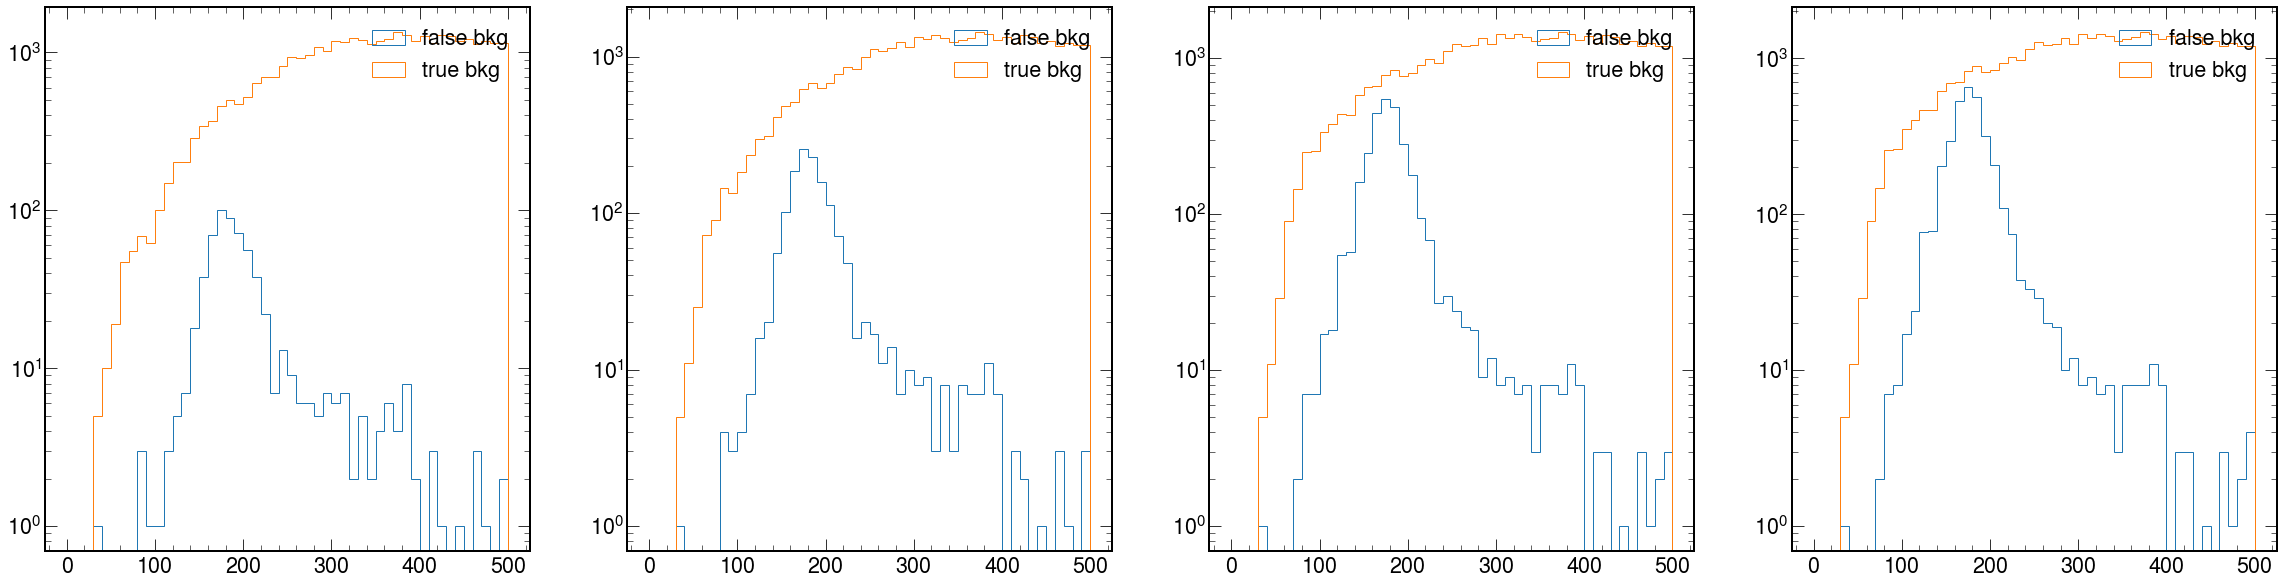

In [52]:
fig, ax = plt.subplots(ncols = 4, figsize = (40, 10))
bins = 50
rg = [0,500]
for n, tr in enumerate(tresholds.values()):
    ax[n].hist(X_mass[:,1][(pred_all.flatten()<tr)*(y.flatten()==1)], histtype = 'step',range = rg, bins = bins, label = 'false bkg' )
    ax[n].hist(X_mass[:,1][(pred_all.flatten()<tr)*(y.flatten()==0)], histtype = 'step',range = rg, bins = bins, label = 'true bkg' )
    ax[n].legend()
    ax[n].set_yscale('Log')
    print('false negative rate, true negative rate')
    print(len(X_mass[:,1][(pred_all.flatten()<tr)*(y.flatten()==1)])/len(X_mass[:,1][(y.flatten()==1)]), len(X_mass[:,1][(pred_all.flatten()<tr)*(y.flatten()==0)])/len(X_mass[:,1][(y.flatten()==0)]))
plt.savefig(folder+'mass_undertrs.png')

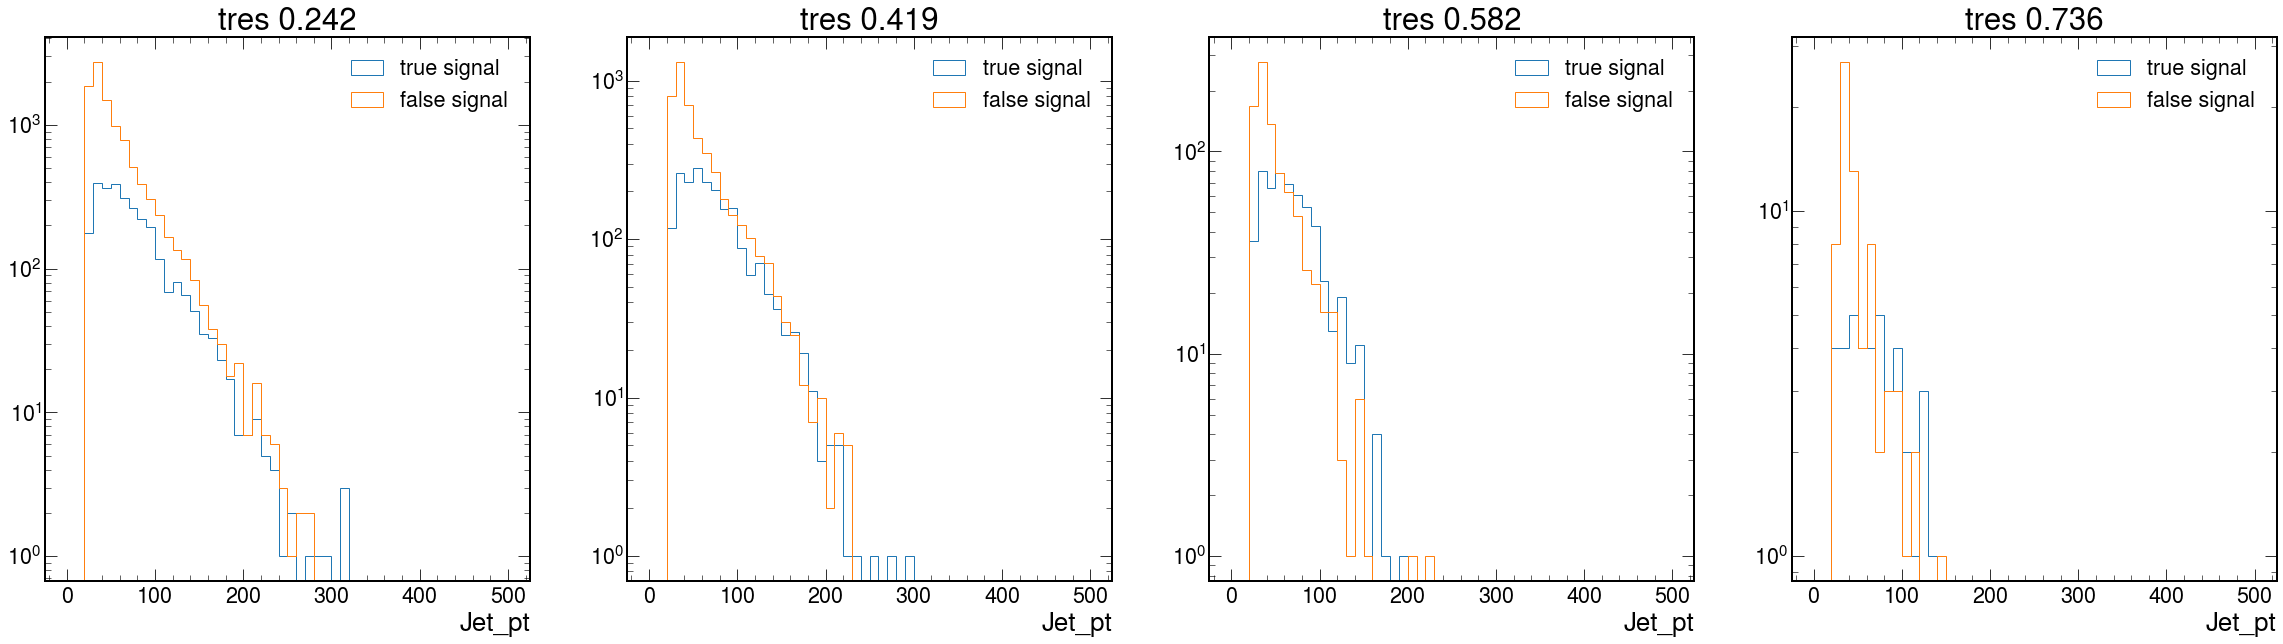

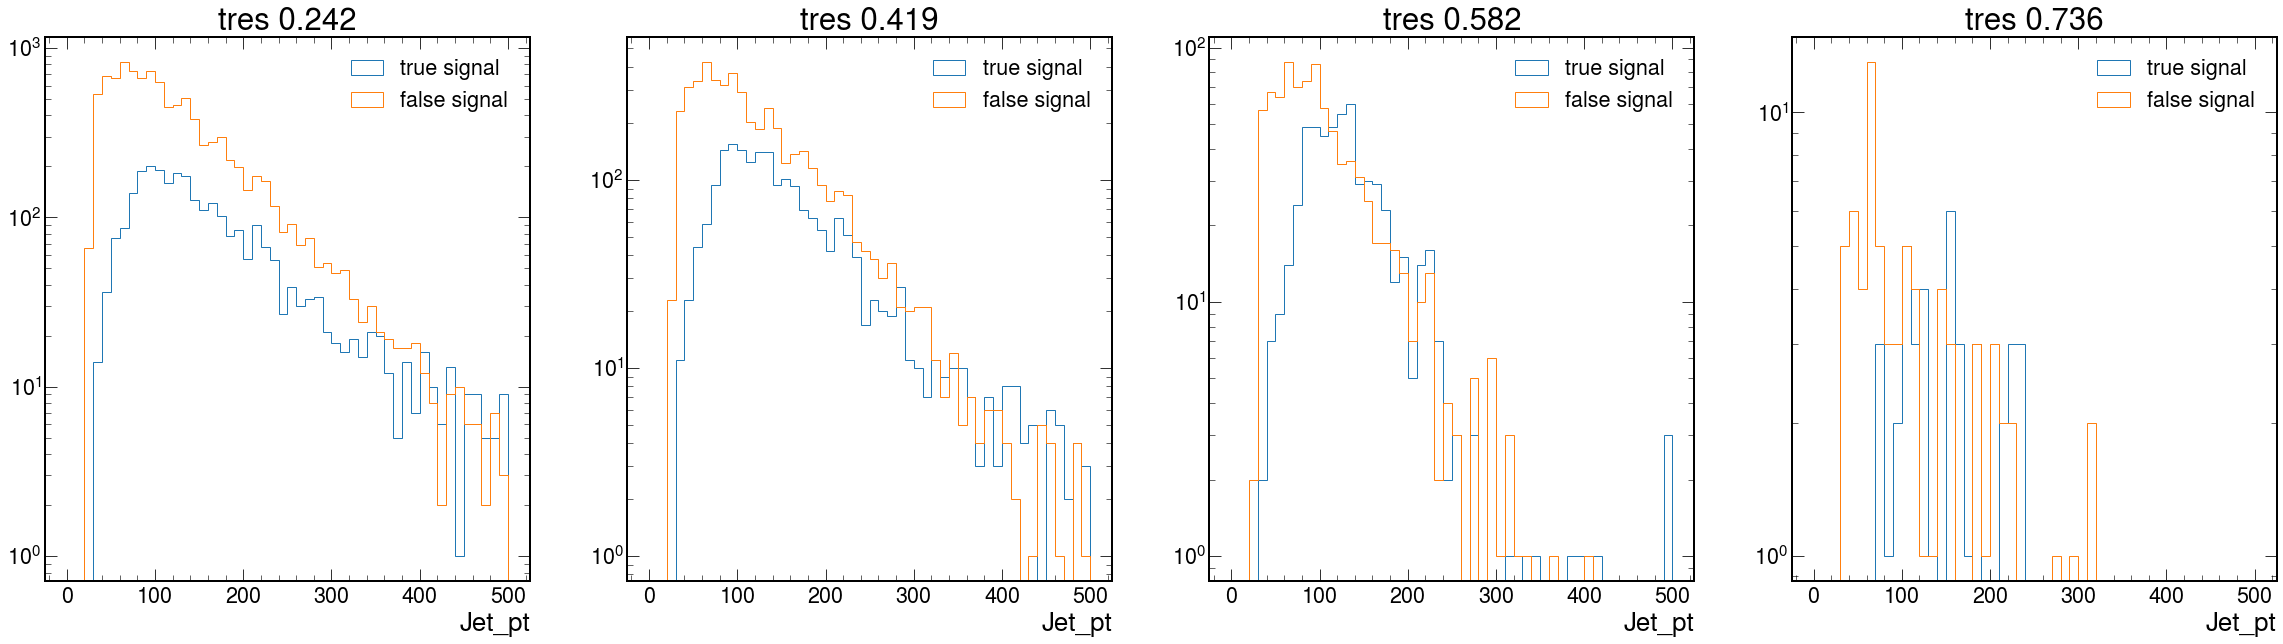

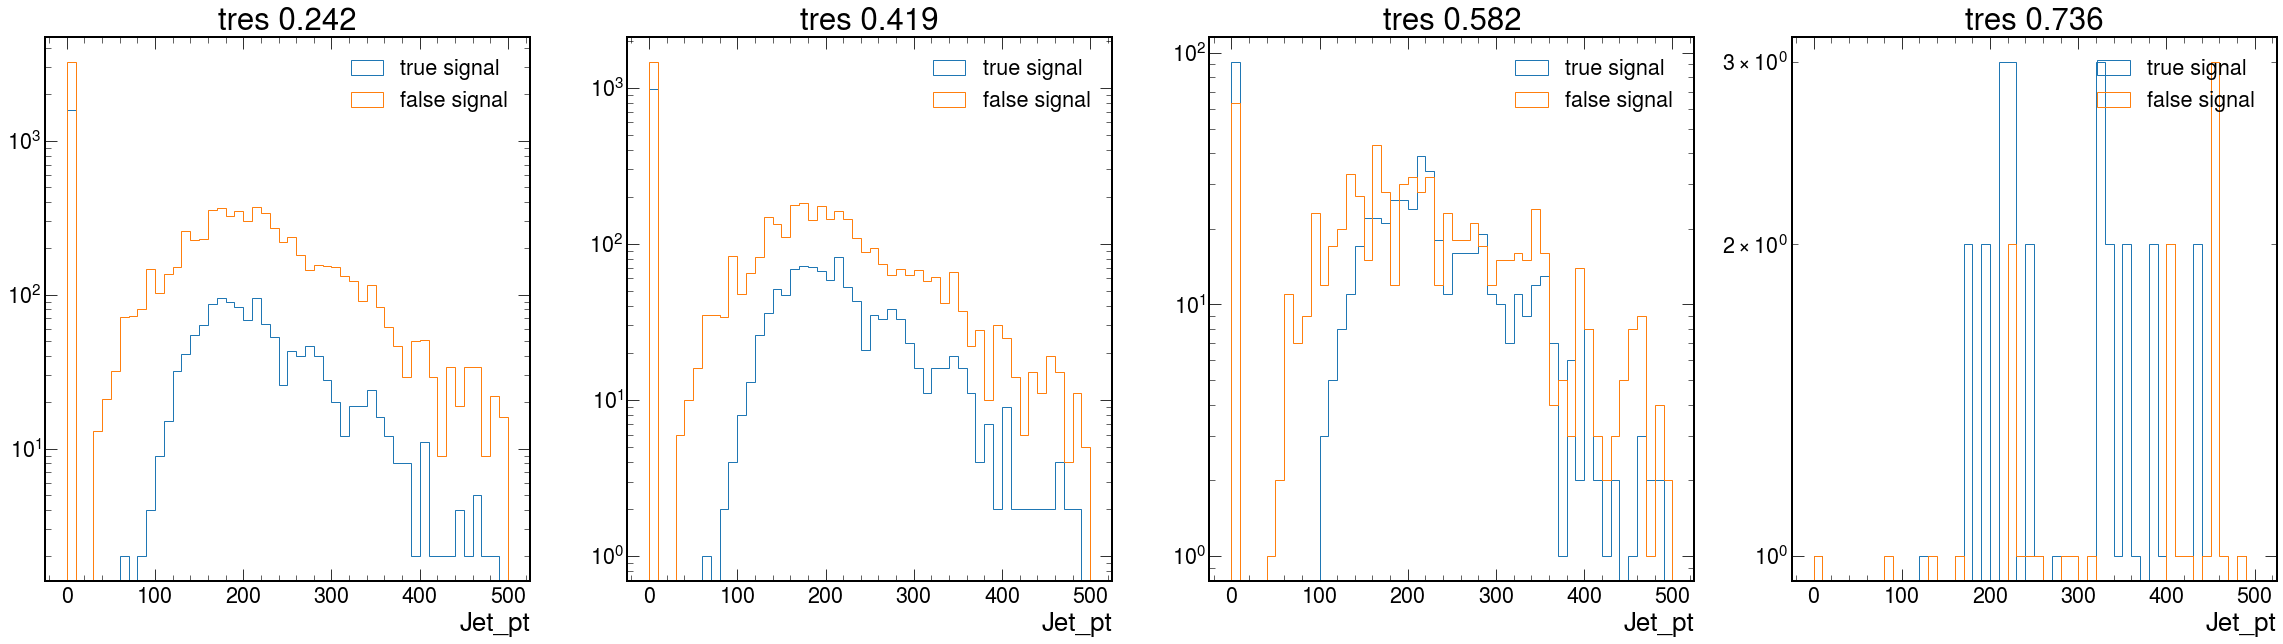

In [53]:
for j in range(3):
    fig, ax = plt.subplots(ncols = 4, figsize = (40, 10))
    bins = 50
    rg = [0,500]
    for n, t in enumerate(tresholds.values()):
        ax[n].hist(X_jet[:, j, 5][(pred_all.flatten()>t)*(y.flatten()==1)], histtype = 'step',range = rg, bins = bins, label = 'true signal' )
        ax[n].hist(X_jet[:, j, 5][(pred_all.flatten()>t)*(y.flatten()==0)], histtype = 'step',range = rg, bins = bins, label = 'false signal' )
        ax[n].legend()
        ax[n].set_title('tres '+str(round(t, 3)))
        ax[n].set_yscale('Log')
        ax[n].set_xlabel('Jet_pt')
plt.savefig(folder+'jetpt_overtrs.png')

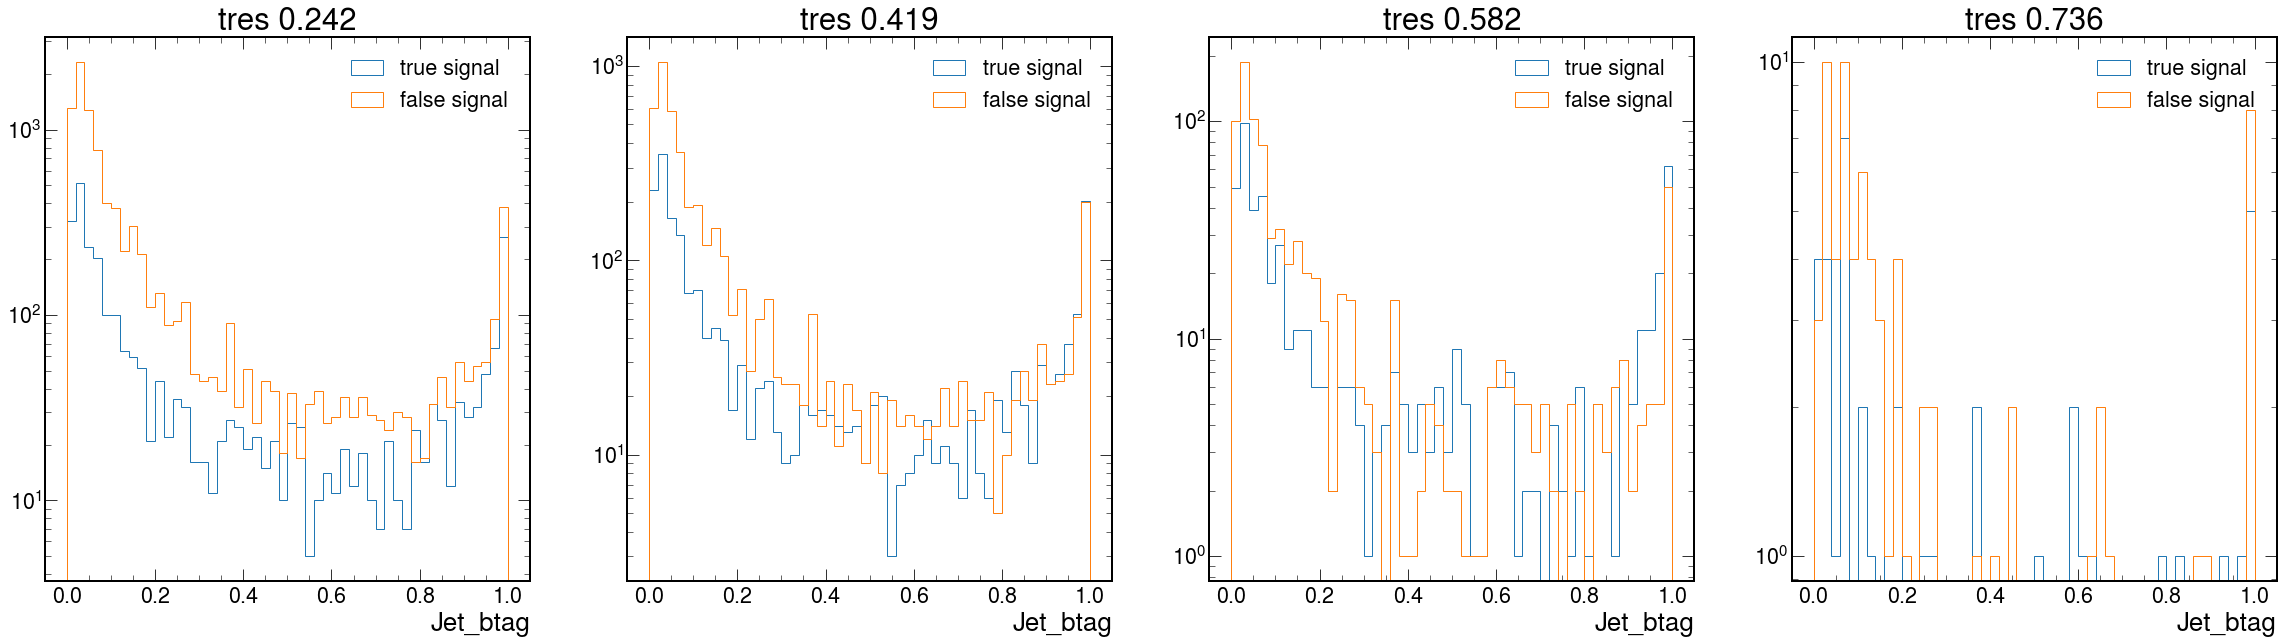

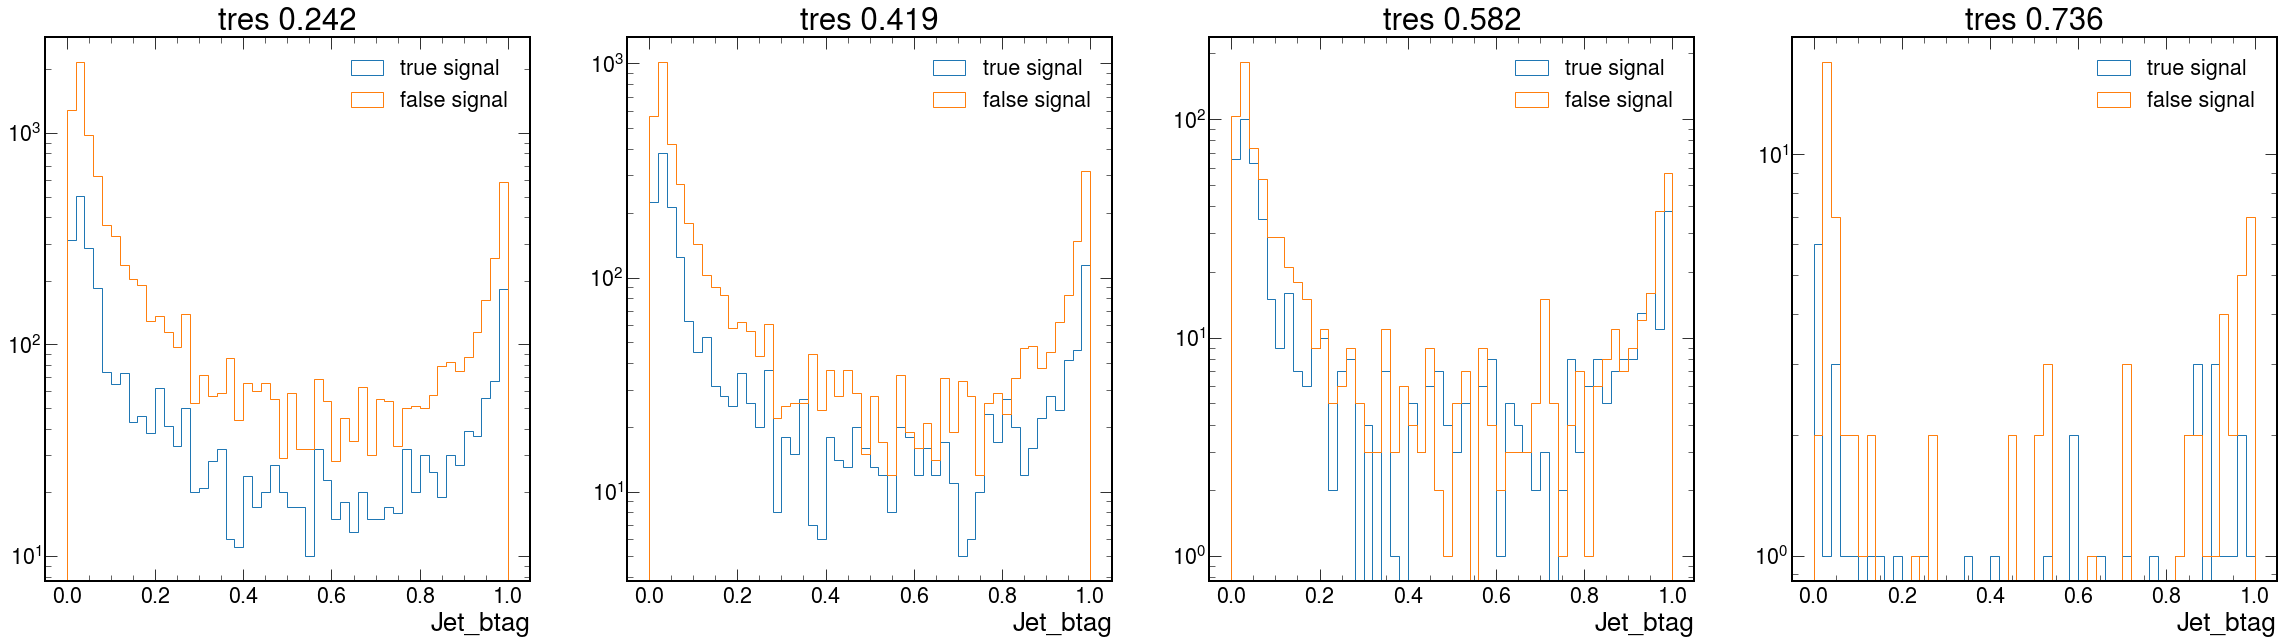

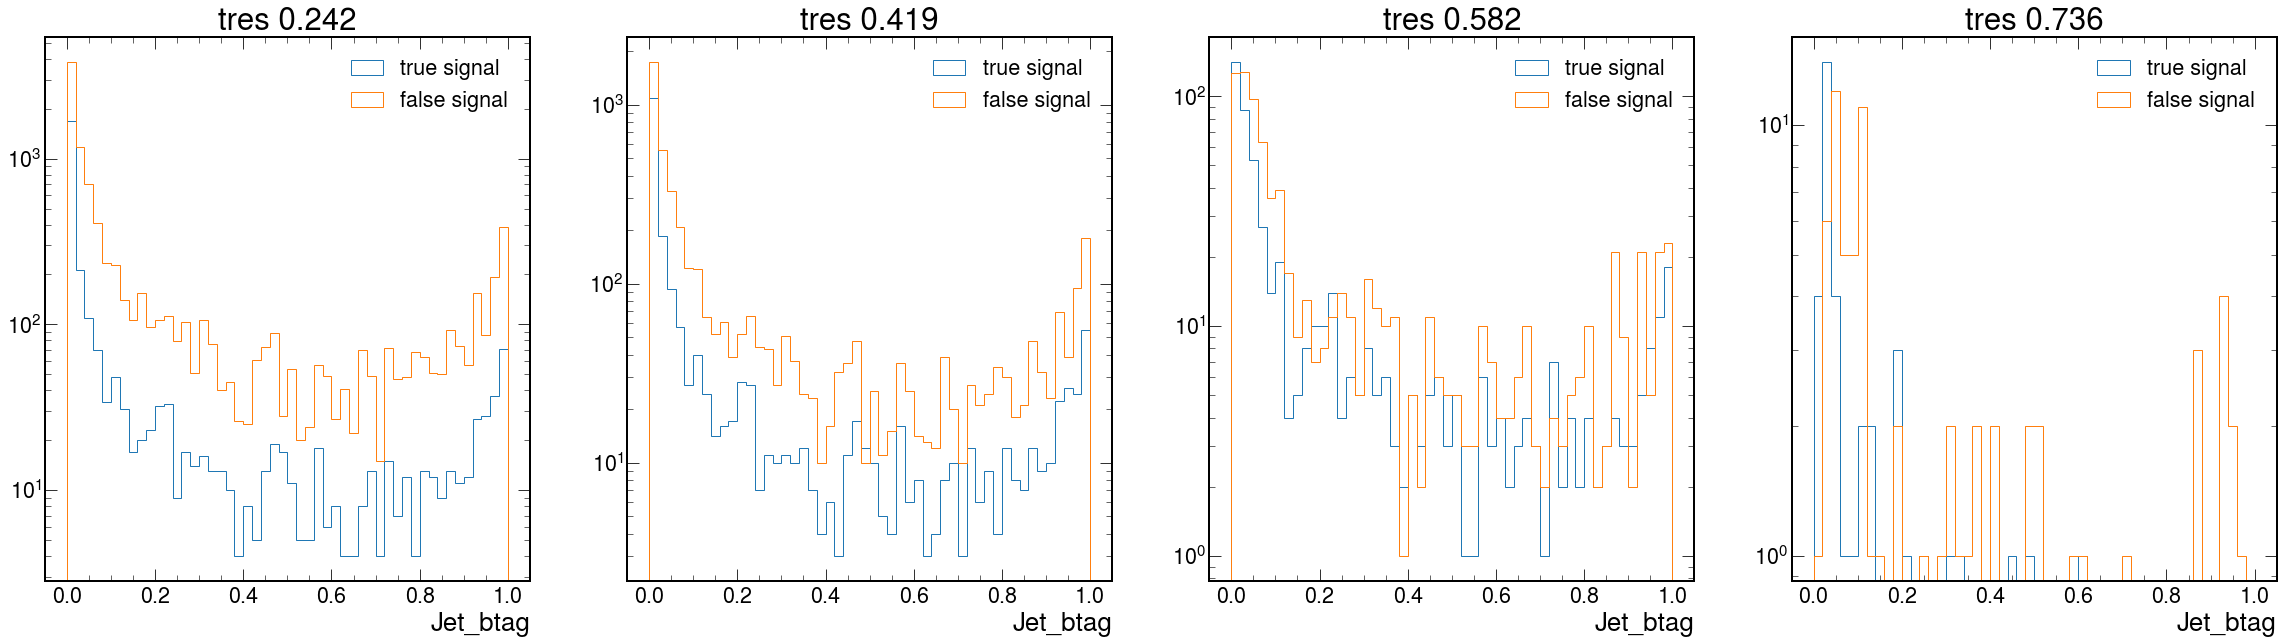

In [54]:
for j in range(3):
    fig, ax = plt.subplots(ncols = 4, figsize = (40, 10))
    bins = 50
    rg = [0,1]
    for n, t in enumerate(tresholds.values()):
        ax[n].hist(X_jet[:, j, 1][(pred_all.flatten()>t)*(y.flatten()==1)], histtype = 'step',range = rg, bins = bins, label = 'true signal' )
        ax[n].hist(X_jet[:, j, 1][(pred_all.flatten()>t)*(y.flatten()==0)], histtype = 'step',range = rg, bins = bins, label = 'false signal' )
        ax[n].legend()
        ax[n].set_title('tres '+str(round(t, 3)))
        ax[n].set_yscale('Log')
        ax[n].set_xlabel('Jet_btag')
plt.savefig(folder+'jetbtag_overtrs.png')

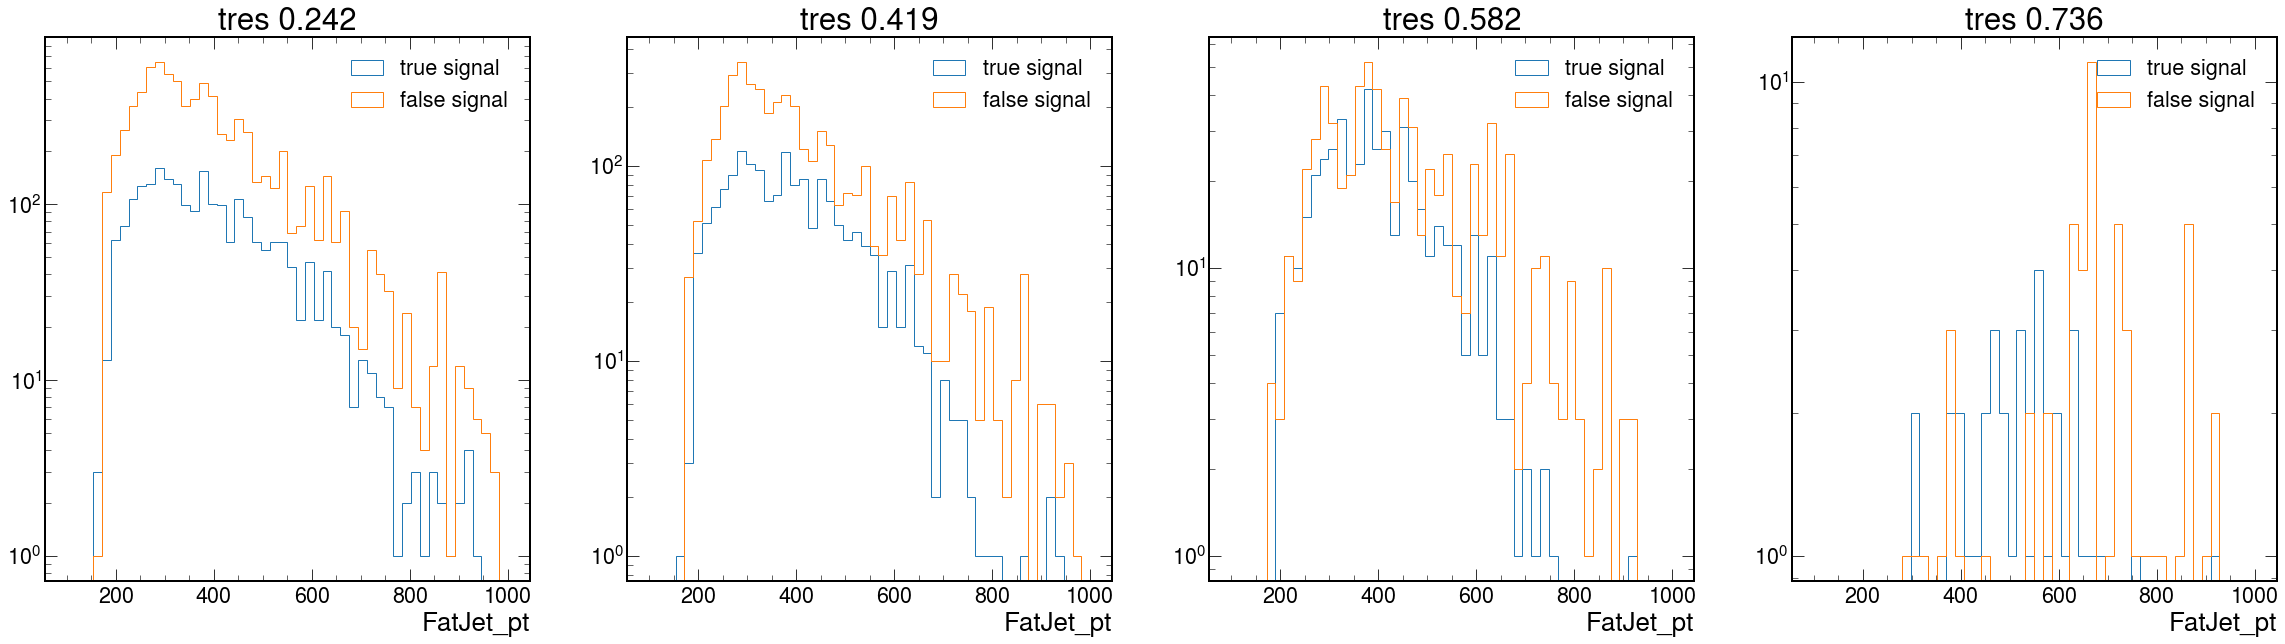

In [55]:
fig, ax = plt.subplots(ncols = 4, figsize = (40, 10))
bins = 50
rg = [100,1000]
for n, t in enumerate(tresholds.values()):
    ax[n].hist(X_fatjet[:, 11][(pred_all.flatten()>t)*(y.flatten()==1)], histtype = 'step',range = rg, bins = bins, label = 'true signal' )
    ax[n].hist(X_fatjet[:, 11][(pred_all.flatten()>t)*(y.flatten()==0)], histtype = 'step',range = rg, bins = bins, label = 'false signal' )
    ax[n].legend()
    ax[n].set_title('tres '+str(round(t, 3)))
    ax[n].set_yscale('Log')
    ax[n].set_xlabel('FatJet_pt')
plt.savefig(folder+'fatjetpt_overtrs.png')